# MUSIC for Direction of Arrival

This notebook is a demo of MUSIC for Direction of Arrival

# Introduction and mathematical background

MUSIC for Direction of Arrival is an algorithm to detect the direction (angle) of $D$ sources using their received signals on $M$ microphones. Assuming the channels are additive white Gaussian noise channels and the signals are narrowband, we have the received signal at microphone $m$, which has position $(x_m, y_m)$ on the $\mathbb{R}^2$ plane, with $\theta_k$ being the angle of source $k$, $x^{(m)}(t)$:

$$x^{(m)}(t)=\sum_{k=1}^D S_k(t)e^{-j \frac{2\pi}{\lambda} (x_m\cos(\theta_k)+y_m\sin(\theta_k))}+n_m(t)$$

Note that we assume that the source is far enough away for the angle to be the same for each microphone. Even though we consider a more general case than [[1]](#paper_1) with microphones that may not be aligned, we assume that they are relatively close compared to the sources, which are at a distance order(s) of magnitude higher than the distance between microphones. Thus, for one source, the angle to all microphones is approximately the same.

$n_m(t)$ is a white Gaussian process with variance $\sigma^2$, independent for each microphone, $\lambda$ is the wavelength and $S_k(t)$ is the wavefront signal, assumed to be narrowband.

Note that by writing $a_m(\theta_k)=e^{-j \frac{2\pi}{\lambda} (x_m\cos(\theta_k)+y_m\sin(\theta_k))}$, we have

$$x^{(m)}(t)=\sum_{k=1}^D a_m(\theta_k)S_k(t)+n_m(t)$$

We will use this below to rewrite this as a matrix equation.

<font color='#655588'>
    
## Proof of the angle distance:
    
Since the distance between microphones is relative (we can place the origin and orientation of the coordinate system whereever we want), we can compare the (possibly negative) "additional distance" travelled by a microphone to the origin. Let us take a generic microphone at $(x, y)$ and see what happens compared to the origin.
    
For simplicity, we define the angle $\varphi$ as in the drawing. We start by noticing that $\cos\varphi=\frac{d}{\sqrt{x^2+y^2}}$ and recalling that $\cos(a-b)=\cos a \cos b + \sin a \sin b$. Also, note that the two parallel lines are the lines from the source to $(x, y)$ and to the origin respectively. We again assume that the points are far enough away so that the angles between those points and the source are the same, hence why the lines are parallel. The source signal "reaches" $(x, y)$ first and then has to go through an additional distance $d$ to reach the origin. So our goal is to express $d$ in terms of $x, y$ and $\theta$. Let's get to it:
    
<img src="img/non_aligned_mics.jpeg" />

We see that $arctan(\frac{y}{x})=\theta+\varphi$, so $\varphi=arctan(\frac{y}{x})-\theta$. Then, we can use the decomposition formula above.

First, $\frac{d}{\sqrt{x^2+y^2}}=\cos(\varphi)=\cos(arctan(\frac{y}{x})-\theta)=\cos(arctan(\frac{y}{x}))\cos(\theta)+\sin(arctan(\frac{y}{x}))\sin(\theta)$.
    
Since $cos(\alpha)=\frac{1}{\sqrt{1+\tan^2(\alpha)}}$ and $sin(\beta)=\sqrt{1-cos^2(\beta)}=\sqrt{1-\frac{1}{1+\tan^2(\beta)}}=\sqrt{\frac{1+\tan^2(\beta)-1}{1+\tan^2(\beta)}}=\frac{\tan(\beta)}{\sqrt{1+\tan^2(\beta)}}$, this becomes:
    
$\frac{d}{\sqrt{x^2+y^2}}=\frac1{\sqrt{1+\frac{y^2}{x^2}}}\cos(\theta)+\frac{\frac{y}{x}}{\sqrt{1+\frac{y^2}{x^2}}}\sin(\theta)=\frac{x}{\sqrt{x^2+y^2}}\cos(\theta)+\frac{y}{\sqrt{x^2+y^2}}\sin(\theta)$
    
and finally, this implies that $d=x\cos(\theta)+y\cos(\theta)$.
    
Note that our $\theta$ is not the same as the angle we used before (the one we used before was actually $\frac{\pi}2-\theta$), but this does not matter as we only calculate the additional distance and as long as we stick to a single convention.

</font>

In vector form, this can also be written as

$$X=AS+N$$ 
(todo add dependency on t?)

where

$$X=\begin{pmatrix} x^{(1)}(t) \\ x^{(2)}(t) \\ ... \\ x^{(M)}(t)\end{pmatrix}, \ \ S = \begin{pmatrix} S_1(t) \\ S_2(t) \\ ... \\ S_D(t)\end{pmatrix}, \ \ N = \begin{pmatrix} n_1(t) \\ n_2(t) \\ ... \\ n_M(t)\end{pmatrix}$$


and $A$ is an $M\times D$ matrix such that the entry at the $m^{\text{th}}$ row and $k^{\text{th}}$ column is $A_{m,k}=e^{-j \frac{2\pi}{\lambda} (x_m\cos(\theta_k)+y_m\sin(\theta_k))}$. That is, using our earlier notation, $A_{m,k}=a_m(\theta_k)$.

Using calculations seen and done in class, we have the auto-correlation matrix $R_X=AR_SA^H+\sigma ^2 I$ (replaced by the empirical estimation in practice) and its eigenvalues and eigenvectors $v_i$ and $\lambda_i$ for $1\leq i \leq M$, with the eigenvalues sorted in decreasing order ($\lambda_i\geq \lambda_{i+1}$).

The first $D$ eigenvalues and eigenvectors correspond to the signal subspace where as the remaining eigenvalues correspond to the noise subspace and should be $\lambda_i=\sigma^2$ for $D<i\leq M$.

Using the fact that for such $i$, $R_X v_i= \sigma^2v_i$ and subtituting our expression for $R_X$ into this, we find that $A^Hv_i=0$, from which we can construct the $M\times (M-D)$ noise matrix $E_n$ with the noise eigenvectors and therefore the spatial spectrum $P(\theta)$ as follows:

$$E_n= \begin{pmatrix} v_{D+1} & ... & v_{M}\end{pmatrix}$$

$$P(\theta)=\frac{1}{||E_n^Ha(\theta)||^2}$$

where $a(\theta)=\begin{pmatrix} a_1(\theta) \\ ... \\ a_M(\theta)\end{pmatrix}$.

Then, the maximum values of $P(\theta)$ (the peaks) should correspond to the angles $\theta_1$ to $\theta_D$, i.e. the angles of the $D$ sources.

Note that apart from the additional proof, all of this was seen in class and/or in [[1]](#paper_1) and is thus not described in full detail (as it is something we had to understand, but not actually do).

# Methods

In this part, we implement the workflow of MUSIC for DOA described above and test it on real and simulated data. The results are discussed below.

## Simulated data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks

import sys
sys.path.append("src")

from music import *
from music_advanced import *
from simulated_signal import *

In [2]:
# Constants
thetas = np.array([0.5, 1]) # in radians (should be in [0, pi/2])
n_sources = len(thetas)
w0 = np.pi / 5
n_mics = 20
mic_distance = 1
noise_var = 3
fs = 2000

mic_coords = np.array([(0, mic_distance * i) for i in range(n_mics)]).T
main_frequency = (fs * w0) / (2 * np.pi)
wavelength = SOUND_SPEED / main_frequency

### Craft the signal

As mentioned in our first section, we have 2 ways of crafting a simulated signal:

1. With a simulated function that we sample
2. Directly with the matrices containing the samples of our function

We start with the simulated function:

Note that here, we suppose that $x_m=0$ for all $m$ and $y_m=d\cdot (m-1)$, where $d$ is the distance between mics. This is how `received_signal` is implemented. That is, our earlier equation

$$x^{(m)}(t)=\sum_{k=1}^D S_k(t)e^{-j \frac{2\pi}{\lambda} (x_m\cos(\theta_k)+y_m\sin(\theta_k))}+n_m(t)$$

becomes

$$x^{(m)}(t)=\sum_{k=1}^D S_k(t)e^{-j \frac{2\pi}{\lambda} d (m-1) \sin(\theta_k)}+n_m(t)$$

In [3]:
narrowband_signals = [narrowband_signal(k, w0) for k in range(n_sources)]
received_signals = [received_signal(thetas, narrowband_signals, 
                                    mic_index=m+1, 
                                    main_frequency=main_frequency,
                                    mic_distance=mic_distance, 
                                    noise_var=noise_var) for m in range(n_mics)]

n_samples = 100

sampled_received = np.zeros((len(received_signals), n_samples), dtype=np.csingle)

for i, received in enumerate(received_signals):
    for j in range(n_samples):
        sampled_received[i, j] = received(j / fs)

sampled_received.shape

(20, 100)

Directly with the samples in matrix form:

Just like before, $x_m=0$ and $y_m=d\cdot(m-1)$, so $A$ becomes a Vandermonde Matrix, namely:

$$A_{m,k}=e^{-j \frac{2\pi}{\lambda} d(m-1)\sin(\theta_k)}$$
so with $\varphi_k=-\frac{2\pi}{\lambda}d\sin(\theta_k)$

$$A = \begin{pmatrix} 1 & 1 & ... & 1\\ e^{-j \frac{2\pi}{\lambda} d\sin(\theta_1)}&e^{-j \frac{2\pi}{\lambda} d\sin(\theta_2)}&...&e^{-j \frac{2\pi}{\lambda} d\sin(\theta_D)} \\ ... \\  e^{-j \frac{2\pi}{\lambda} d(M-1)\sin(\theta_1)}&e^{-j \frac{2\pi}{\lambda} d(M-1)\sin(\theta_2)}&...&e^{-j \frac{2\pi}{\lambda} d(M-1)\sin(\theta_D)}\end{pmatrix}= \begin{pmatrix} 1 & 1 & ... & 1\\ e^{j\varphi_1}&e^{j \varphi_2}&...&e^{j \varphi_D} \\ ... \\  e^{j (M-1)\varphi_1}&e^{j (M-1)\varphi_2}&...&e^{j (M-1)\varphi_D}\end{pmatrix}$$


In [4]:
phis = np.array([np.exp(-2j * np.pi * mic_distance * np.sin(theta) / wavelength) for theta in thetas])
A = np.vander(phis, n_mics, increasing=True).T
S = np.random.normal(0, 1, (n_sources, n_samples))
noise_matrix = np.random.normal(0, noise_var, (n_mics, n_samples, 2)).view(np.complex128)\
                                    .reshape((n_mics, n_samples))

sampled_received = (A @ S) + noise_matrix

Note that both implementations are correct and give the same result as long as $S$ is represented by the same function as `narrowband_signal` and sampled the same way. Here, in the first example, $S_k(t)=f(k, t)e^{-j \cdot \omega_0 \cdot t}$ where $f(k, t)$ is deterministic function of $k$ and $t$ whereas the samples in the second case are realisations or a Gaussian process with mean $0$ and variance $1$, so they are not actually the same in this case.

### Music implementation

Finally, we test out implementation of MUSIC (found in the python files in the `src` folder) on our simulated data. It works well! 

Samples shape: (20, 100)
Covariance shape: (20, 20)


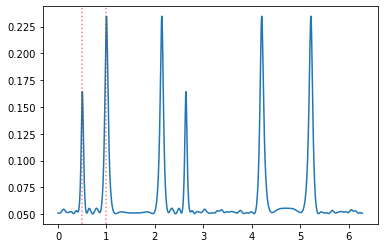

In [5]:
spectrum = music(sampled_received, n_sources, mic_coords, main_frequency)

X = np.linspace(0, 2 * np.pi, 10000)
Y = [spectrum(x) for x in X]

plt.plot(X, Y)
for theta in thetas:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)
plt.show()

Extract the frequencies from the peaks. Note that our method only works for theta in $\left[0, \frac{\pi}{2} \right]$ because of the symmetry of the complex exponential and sinus function.

In [6]:
estimated_thetas = extract_frequencies(spectrum, n_sources, [0, np.pi / 2])
print('estimated thetas:', estimated_thetas)
print('actual thetas:   ', thetas)

estimated thetas: [0.50171235 0.99918354]
actual thetas:    [0.5 1. ]


## Real data

Now, instead of crafting a signal, let's use pyroom acoustics and existing `.wav` files. We build on last year's project for the positions of the microphones.

In [7]:
import pyroomacoustics as pra
from scipy.io import wavfile
import IPython

import scipy
import json

In [8]:
fs, data = wavfile.read('res/arctic_a0010.wav')
data_variance = np.var(data)
IPython.display.Audio(data, rate=fs)

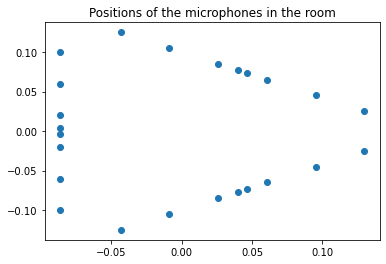

In [9]:
with open('../music_doa/last_year/protocol.json') as json_file:  
    protocol = json.load(json_file)
    
microphone_3D_locations = np.array(protocol['geometry']['microphones']['locations'])
top_mics = np.isclose(microphone_3D_locations[:,2], 0.06123724)
microphone_2D_locations = microphone_3D_locations[top_mics, :2]

plt.scatter(microphone_2D_locations[:, 0], microphone_2D_locations[:, 1])
plt.title("Positions of the microphones in the room")
plt.show()

In [10]:
# More constants
sigma2 = 10.0 * data_variance
distance = 3.  # meters

We now create the room using pyroom acoustics and add the microphone array as well as a source.

(<Figure size 432x288 with 1 Axes>, <Axes: >)

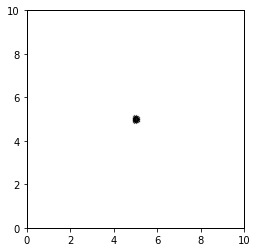

In [11]:
room_dim = np.r_[10.,10.]
aroom = pra.ShoeBox(room_dim, fs=fs, max_order=0, sigma2_awgn=sigma2)

# Adding the microphones

mics_coords = (microphone_2D_locations + room_dim / 2).T
aroom.add_microphone_array(pra.MicrophoneArray(mics_coords, aroom.fs))

aroom.plot()

(<Figure size 432x288 with 1 Axes>, <Axes: >)

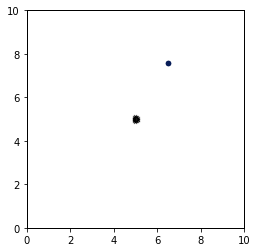

In [12]:
# Add sources of 1 second duration
azimuth = np.array([60]) / 180. * np.pi

rng = np.random.RandomState(23)
duration_samples = 10000

for ang in azimuth:
    random_phase = np.random.uniform(0, 2 * np.pi)
    source_location = room_dim / 2 + distance * np.r_[np.cos(ang), np.sin(ang)]
    aroom.add_source(source_location, signal=data)
    
# Run the simulation
aroom.simulate()
aroom.plot()

This is what the first microphone picked up: (todo, is this what the recording is?)

In [13]:
IPython.display.Audio(aroom.mic_array.signals[0], rate=fs)

Now let's have a look at the FFT of the original audio file. The goal is to get the main frequency range of our signal for the STFT version of music (stay tuned!)

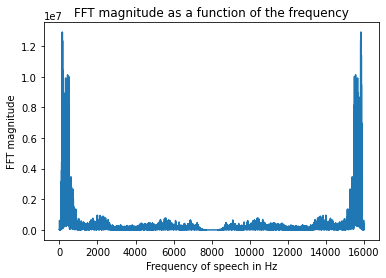

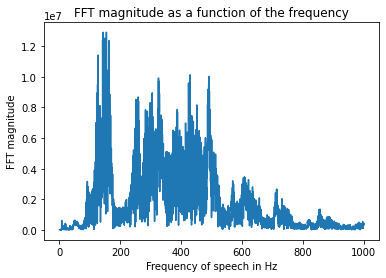

In [14]:
fft = np.fft.fft(data)
frequencies = np.linspace(0, fs, len(fft))

plt.plot(frequencies, abs(fft))
plt.xlabel("Frequency of speech in Hz")
plt.ylabel("FFT magnitude")
plt.title('FFT magnitude as a function of the frequency')
plt.show()

selected_ids = np.argwhere(frequencies < 1000)
selected_freq = frequencies[selected_ids]
selected_fft = fft[selected_ids]

plt.plot(selected_freq, abs(selected_fft))
plt.xlabel("Frequency of speech in Hz")
plt.ylabel("FFT magnitude")
plt.title('FFT magnitude as a function of the frequency')
plt.show()

We observe that our signal (without the noise) only spans a very small subset of frequencies. Thus, with the STFT version of MUSIC allows us to only focus on the relevant frequencies of our signal and get rid of a part of the noise that spans the whole frequency range.

The frequency range of interest is approximately [0, 500] Hz (this will be useful for the STFT version of MUSIC). 
On the other hand however, because of the narrowband assumption of standard MUSIC, we can only focus on a single frequency :(

Let's take the biggest spike which is roughly at 150 Hz

In [15]:
pra_main_frequency = 150
pra_freq_range = [0, 500]

Samples shape: (24, 57268)
Covariance shape: (24, 24)


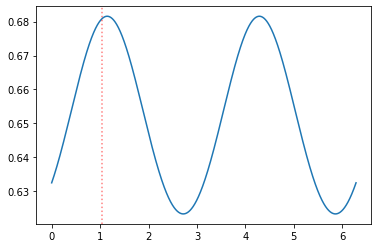

In [16]:
n_sources = len(azimuth)

spectrum = music(aroom.mic_array.signals, n_sources, mics_coords, pra_main_frequency)

X = np.linspace(0, 2 * np.pi, 10000)
Y = [spectrum(x) for x in X]

plt.plot(X, Y)
for theta in azimuth:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)
plt.show()

In [17]:
estimated_thetas = extract_frequencies(spectrum, 1, [0, np.pi / 2])
print(f'estimated angle in radians = {estimated_thetas[0]:.4f}, and in degrees = {estimated_thetas[0]/np.pi*180}')
print(f'true      angle in radians = {azimuth[0]:.4f}, and in degrees = {azimuth[0]/np.pi*180}')

estimated angle in radians = 1.1456, and in degrees = 65.637
true      angle in radians = 1.0472, and in degrees = 60.0


When we apply MUSIC for DOA to the received data, this is what we get. Clearly, it's not great: the peaks are not very precise, nor is the angle of our signal source at one of the peaks. With less or even no noise, the angle is exactly at the first peak, but the spectrum is not any clearer. Indeed, the estimated direction of arrival angle roughly close to the true angle, but not precisely correct. (todo what am i even saying)

## Real real data

So far, we used real data as signal from the source, but we still used a simulation with pyroom acoustics to retrieve the signals received at the microphones. Now, let's have a look at *real* real data. That is, instead of simulating the channels, we directly use read data arrived at microphones and see if our implementation of the MUSIC detects the direction of arrival correctly.

In [18]:
fs, data = wavfile.read('last_year/fq_sample3_spkr0_angle30.wav')
data = data[:, top_mics].T
angle_rad = 30 / 180 * np.pi # should be adapted based on "angleXX" in file name

As above, we look at the Fourier transform of the data to get the main frequency of the signal.

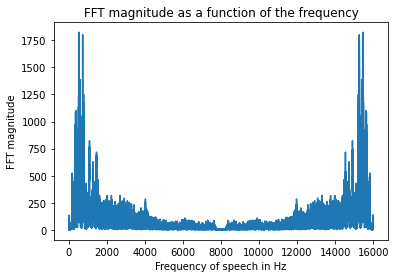

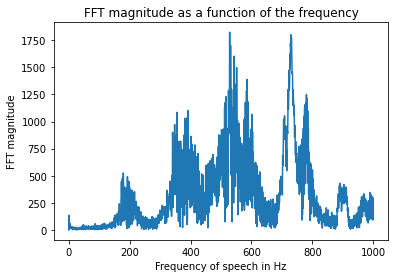

In [19]:
normalized_data = (data[0] - np.mean(data[0])) / np.std(data[0])

fft = np.fft.fft(normalized_data)
frequencies = np.linspace(0, fs, len(fft))

plt.plot(frequencies, abs(fft))
plt.xlabel("Frequency of speech in Hz")
plt.ylabel("FFT magnitude")
plt.title('FFT magnitude as a function of the frequency')
plt.show()

selected_ids = np.argwhere(frequencies < 1000)
selected_freq = frequencies[selected_ids]
selected_fft = fft[selected_ids]

plt.plot(selected_freq, abs(selected_fft))
plt.xlabel("Frequency of speech in Hz")
plt.ylabel("FFT magnitude")
plt.title('FFT magnitude as a function of the frequency')
plt.show()

There seems to be 2 different spikes, one at 500 Hz and another one at 700 Hz. Let's take the middle at 600 Hz

Samples shape: (24, 37885)
Covariance shape: (24, 24)


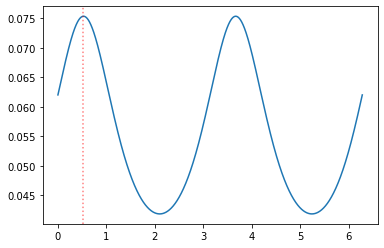

In [20]:
main_frequency = 600
spectrum = music(data, 1, mics_coords, main_frequency) 

X = np.linspace(0, 2 * np.pi, 10000)
Y = [spectrum(x) for x in X]

plt.plot(X, Y)
plt.axvline(x=angle_rad, color='red', linestyle=':', alpha=0.5)
plt.show()

In [21]:
estimated_theta = extract_frequencies(spectrum, 1, [0, np.pi / 2])[0]
print(f'estimated angle in radians = {estimated_theta:.4f}, and in degrees = {estimated_theta/np.pi*180}')
print(f'true      angle in radians = {angle_rad:.4f}, and in degrees = {angle_rad/np.pi*180}')

estimated angle in radians = 0.5284, and in degrees = 30.275999999999996
true      angle in radians = 0.5236, and in degrees = 30.0


Our implementation seems to work! Note however that the spectrum is, like it was before, not very precise (the peaks are unclear). However, this time, at least, the direction of arrival angle is much closer than our earlier result with "fake" real data.

# Results and Discussion

## Advantages

As noticed before, out initial implementation of MUSIC for DOA detected the angles of the sources well, even in the presence of noise crafted signals. It also works for real signals, so real data for the signals received by the microphone.

## Limitations

Our implementation only detects angles in $[0, \frac{\pi}{2}]$ because of the symmetry of complex exponentials, thus we always assume that the source angles are in that range, which is a strong assumption and not necessarily applicable in real life applications.

For real signals, the results are not as clear: when simulating with pyroom acoustics, the detected angle for one source is not very precise. For both types or "real data", the spectra are not very clear, they look more like sinusoids than peaks at certain directions. (todo, why???)

# Advanced tools

For the advanced tools, we start by implementing a MUSIC for DOA estimation based on the short time Fourier transform, as described in [[2]](#stft_paper). We build on the data obtained through the simulation using pyroom acoustics.

In [22]:
n_sources = len(azimuth)
seg_duration = 1.0

spectrum = music_with_frequency(aroom.mic_array.signals, n_sources, fs,
                                microphone_2D_locations.T, segment_duration=seg_duration, freq_range=pra_freq_range)

Shape of sources STFT: (501, 9, 24)
STFD shape: (24, 24)
Shape of noise eigenvectors: (24, 23)


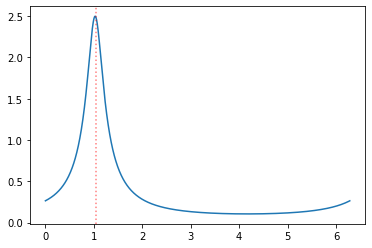

In [23]:
X = np.linspace(0, 2 * np.pi, 1000)
Y = np.array([spectrum(x) for x in X])

plt.plot(X, Y)

for theta in azimuth:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)

plt.show()

In [24]:
print("Extracted frequencies in degrees:", extract_frequencies(spectrum, n_sources, [0, 2 * np.pi])* 180 / np.pi)
print("Real angle in degrees:", azimuth * 180 / np.pi)

Extracted frequencies in degrees: [58.788]
Real angle in degrees: [60.]


Even though the angle is still not exact, it is closer than it was before. Clearly, this is already a big improvement! Additionally, the earlier spectrum looked like a sinusoid with two (very unclear) peaks. Here, we only see one peak. It is still not as clear as it was with crafted signals, but it is already much better than before.

# Sources

<a id='paper_1'></a> 1. H. Tang. [DOA estimation based on MUSIC algorithm](https://www.semanticscholar.org/paper/Examensarbete-DOA-estimation-based-on-MUSIC-Tang-Nordebo/5ff7806b44e60d41c21429e1ad2755d72bba41d7?p2df)

<a id='stft_paper'></a>
2. H. Zhang. [DOA estimation of closely-spaced and spectrally-overlapped sources using a STFT-based MUSIC algorithm](https://www.sciencedirect.com/science/article/abs/pii/S1051200416000312?fr=RR-2&ref=pdf_download&rr=8818b146ad17702e)